# PBS genome-wide selection scans

In [1]:
%run setup.ipynb

In [17]:
df_samples.head()

,ox_code,src_code,population,country,location,site,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,ebi_sample_acc,latitude,longitude
0,AA0040-C,Twifo_Praso__E2,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95033368,30.99,ERS311878,5.60858,-1.54926
1,AA0041-C,Twifo_Praso__H3,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95843804,31.70,ERS311886,5.60858,-1.54926
2,AA0042-C,Takoradi_C7,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,107420666,35.65,ERS311894,4.91217,-1.77397
3,AA0043-C,Takoradi_H8,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,95993752,29.46,ERS311902,4.91217,-1.77397
4,AA0044-C,Takoradi_D10,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,103044262,33.67,ERS311910,4.91217,-1.77397


In [27]:
df_haps_a.groupby(['population', 'region']).size()

population  region           
AOcol       Luanda               156
BFcol       Bana                  12
            Bana M                36
            Bana V                32
            Pala                  20
            Sour                  50
BFgam       Bana                  34
            Bana M                 4
            Bana V                 2
            Pala                  92
            Sour                  52
CIcol       Tiassale             142
CMgam       Daiguene             192
            Gado-Badzere         146
            Mayos                210
            Zembe-Borongo         46
FRgam       Mayotte               48
GAgam       Libreville           138
GHcol       Koforidua              2
            Madina                24
            Takoradi              40
            Twifo_Praso           44
GHgam       Madina                24
GM          KBK                   38
            KSK                   16
            MSN                   36
        

In [25]:
df_samples.groupby(['population', 'location']).size()

population  location      
AOcol       Luanda             78
BFcol       Bana               40
            Pala               10
            Souroukoudinga     25
BFgam       Bana               20
            Pala               46
            Souroukoudinga     26
CIcol       Tiassale           71
CMgam       Daiguene           96
            Gado Badzere       73
            Mayos             105
            Zembe Borongo      23
FRgam       Mayotte            24
GAgam       Libreville         69
GHcol       Koforidua           1
            Madina             12
            Takoradi           20
            Twifo Praso        22
GHgam       Madina             12
GM          Njabakunda         65
GNcol       Koundara            4
GNgam       Koraboh            22
            Koundara           18
GQgam       Bioko               9
GW          Antula             58
            Safim              33
KE          Kilifi             48
UGgam       Tororo            112
dtype: int64

In [14]:
pop1, pop2, pop3 = 'cm_sav_gam', 'gw', 'fr_gam'

In [37]:
def compute_ac(pop, seq_id):
    gt = allel.GenotypeDaskArray(callset_pass[seq_id]['calldata/GT'])

    # fix query for differences between samples and haplotypes metadata
    pop_query = (
        pop_defs[pop]['query']
        .replace('region', 'location')
        .replace('Gado-Badzere', 'Gado Badzere')
        .replace('Zembe-Borongo', 'Zembe Borongo')
    )
    loc_pop = df_samples.query(pop_query).index.values

    assert len(loc_pop) * 2 == len(df_haps_a.query(pop_defs[pop]['query']))

    ac = gt.take(loc_pop, axis=1).count_alleles(max_allele=3)

    return ac


In [88]:
@functools.lru_cache(maxsize=None)
def compute_pbs(pop1, pop2, pop3, seq_id, window_size=100, window_step=100, normed=True, min_maf=None):
    
    # load variant positions
    pos = callset_pass[seq_id]['variants/POS'][:]

    # setup genotypes
    gt = allel.GenotypeDaskArray(callset_pass[seq_id]['calldata/GT'])

    # compute allele counts
    acs = list()
    for pop in pop1, pop2, pop3:

        # fix query for differences between samples and haplotypes metadata
        pop_query = (
            pop_defs[pop]['query']
            .replace('region', 'location')
            .replace('Gado-Badzere', 'Gado Badzere')
            .replace('Zembe-Borongo', 'Zembe Borongo')
        )
        loc_pop = df_samples.query(pop_query).index.values
        assert len(loc_pop) * 2 == len(df_haps_a.query(pop_defs[pop]['query']))
        ac = gt.take(loc_pop, axis=1).count_alleles(max_allele=3)
        acs.append(ac)
    ac1, ac2, ac3 = da.compute(*acs)

    # locate segregating variants
    ac = allel.AlleleCountsArray(ac1 + ac2 + ac3)
    if min_maf:
        loc_seg = ac.is_biallelic_01() & (ac.to_frequencies()[:, :2].min(axis=1) > min_maf)
    else:
        loc_seg = ac.is_segregating()
    ac1 = ac1[loc_seg]
    ac2 = ac2[loc_seg]
    ac3 = ac3[loc_seg]
    pos = pos[loc_seg]
    gpos = np.take(gmap[seq_id], pos-1)
    
    # setup windows
    windows = allel.moving_statistic(pos, statistic=lambda v: [v[0], v[-1]], size=window_size, step=window_step)
    gwindows = allel.moving_statistic(gpos, statistic=lambda v: [v[0], v[-1]], size=window_size, step=window_step)
    
    # compute pbs
    pbs = allel.pbs(ac1, ac2, ac3, window_size=window_size, window_step=window_step, normed=normed)

    return windows, gwindows, pbs

In [93]:
def run_pbs(pop1, pop2, pop3, seq_id, window_size=100, window_step=100, normed=True, markersize=1, min_maf=None):

    windows, gwindows, pbs = compute_pbs(pop1, pop2, pop3, seq_id, window_size=window_size, window_step=window_step, normed=normed, min_maf=min_maf)

    # scale figures to chromosome size
    figwidth = windows.max()/3e6

    # plot results for inspection - physical space
    x = windows.mean(axis=1)
    fig, ax = plt.subplots(facecolor='w', figsize=(figwidth, 3))
    ax.plot(x, pbs, linestyle=' ', mfc='none', marker='o', color='purple', markersize=markersize)
    xticks = ax.get_xticks()
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks/1e6)
    ax.set_xlabel(f'Chromosome {seq_id} position (Mbp)')
    ax.set_ylabel('PBS')
    ax.set_xlim(0, windows.max())
    ax.set_ylim(bottom=0)
    ax.set_title(f"{pop_defs[pop1]['label']}");
    
    # plot results for inspection - genetic space
    x = gwindows.mean(axis=1)
    fig, ax = plt.subplots(facecolor='w', figsize=(figwidth, 3))
    ax.plot(x, pbs, linestyle=' ', mfc='none', marker='o', color='purple', markersize=markersize)
    ax.set_xlabel(f'Chromosome {seq_id} position (cM)')
    ax.set_ylabel('PBS')
    ax.set_xlim(0, gwindows.max())
    ax.set_ylim(bottom=0)
    ax.set_title(f"{pop_defs[pop1]['label']}");
    
    plt.show()
    plt.close()

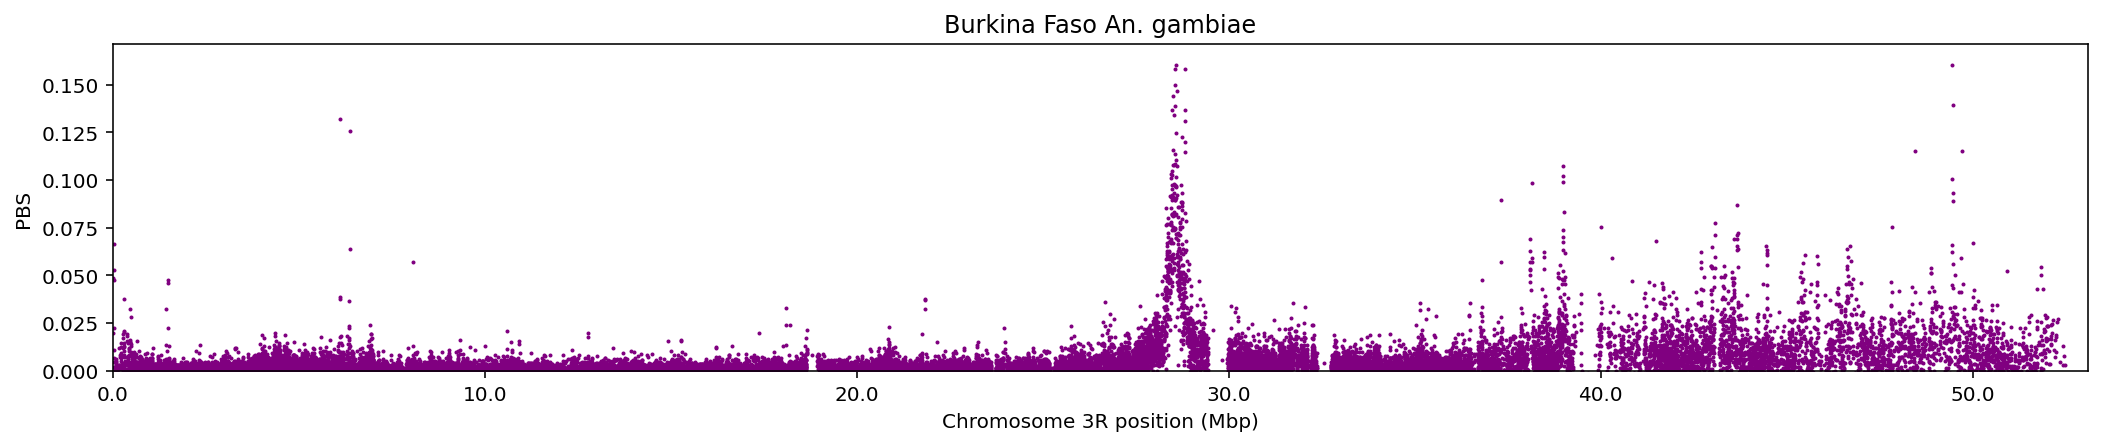

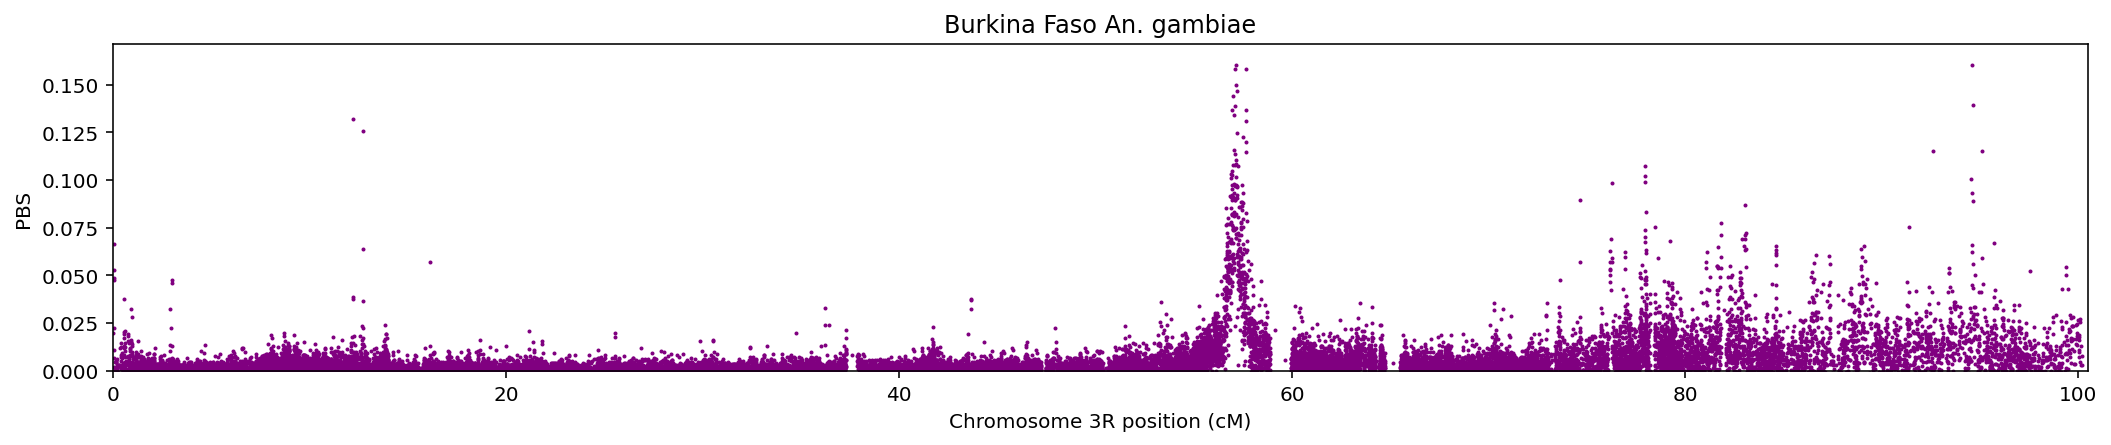

CPU times: user 4min 24s, sys: 4.19 s, total: 4min 29s
Wall time: 28.7 s


In [95]:
run_pbs('bf_gam', 'ug_gam', 'gw', '3R', window_size=300, window_step=300)

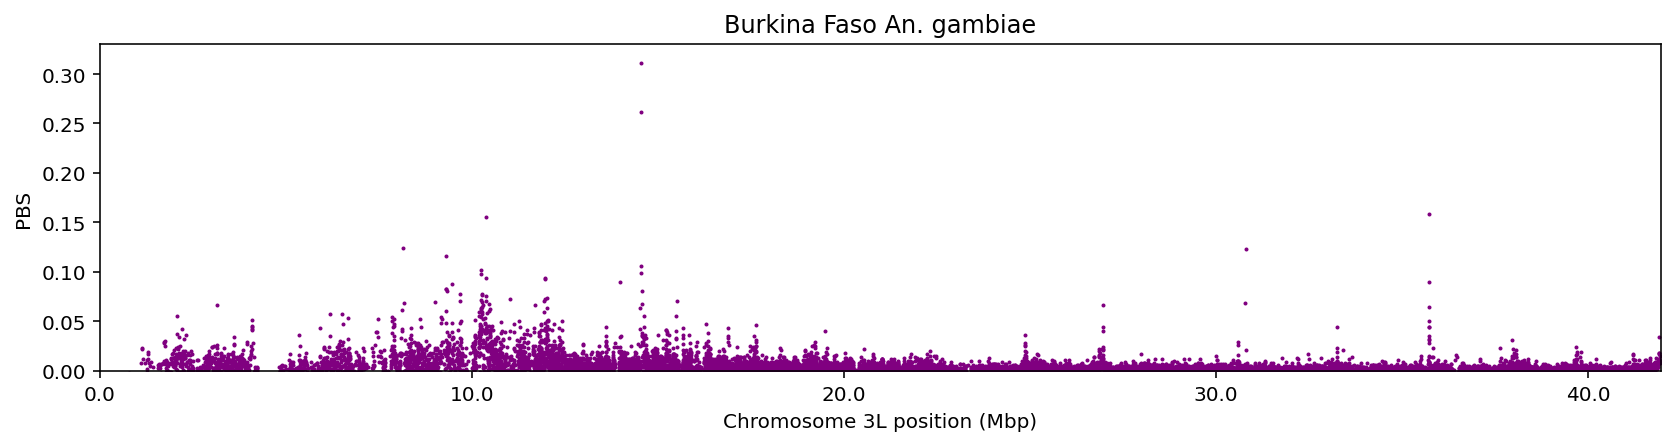

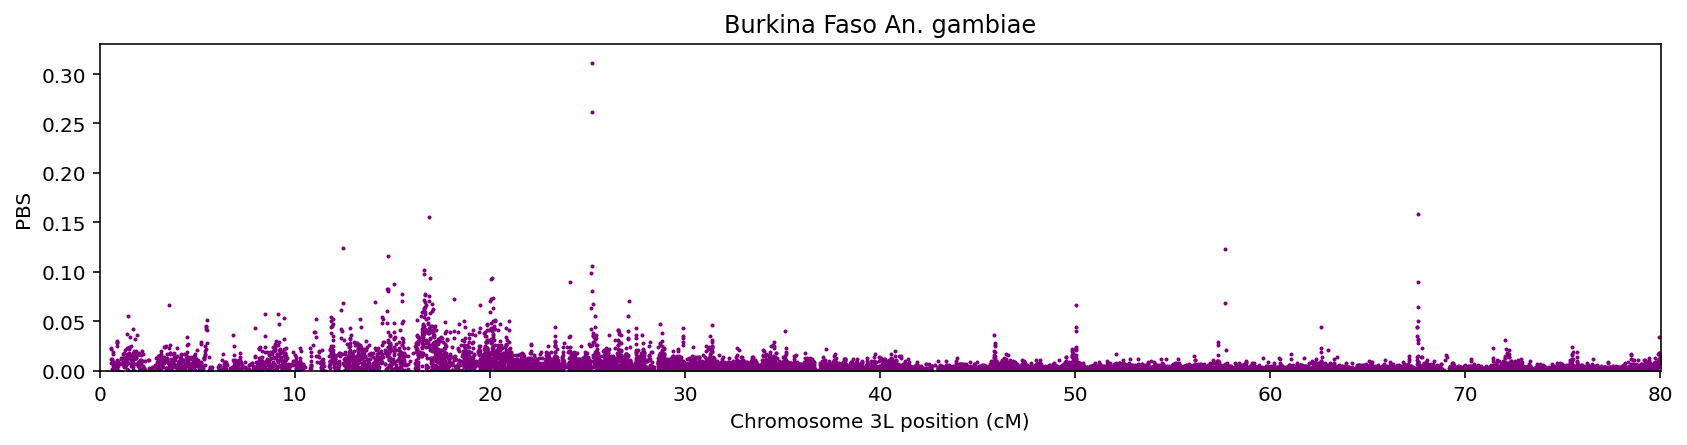

In [96]:
run_pbs('bf_gam', 'ug_gam', 'gw', '3L', window_size=300, window_step=300)

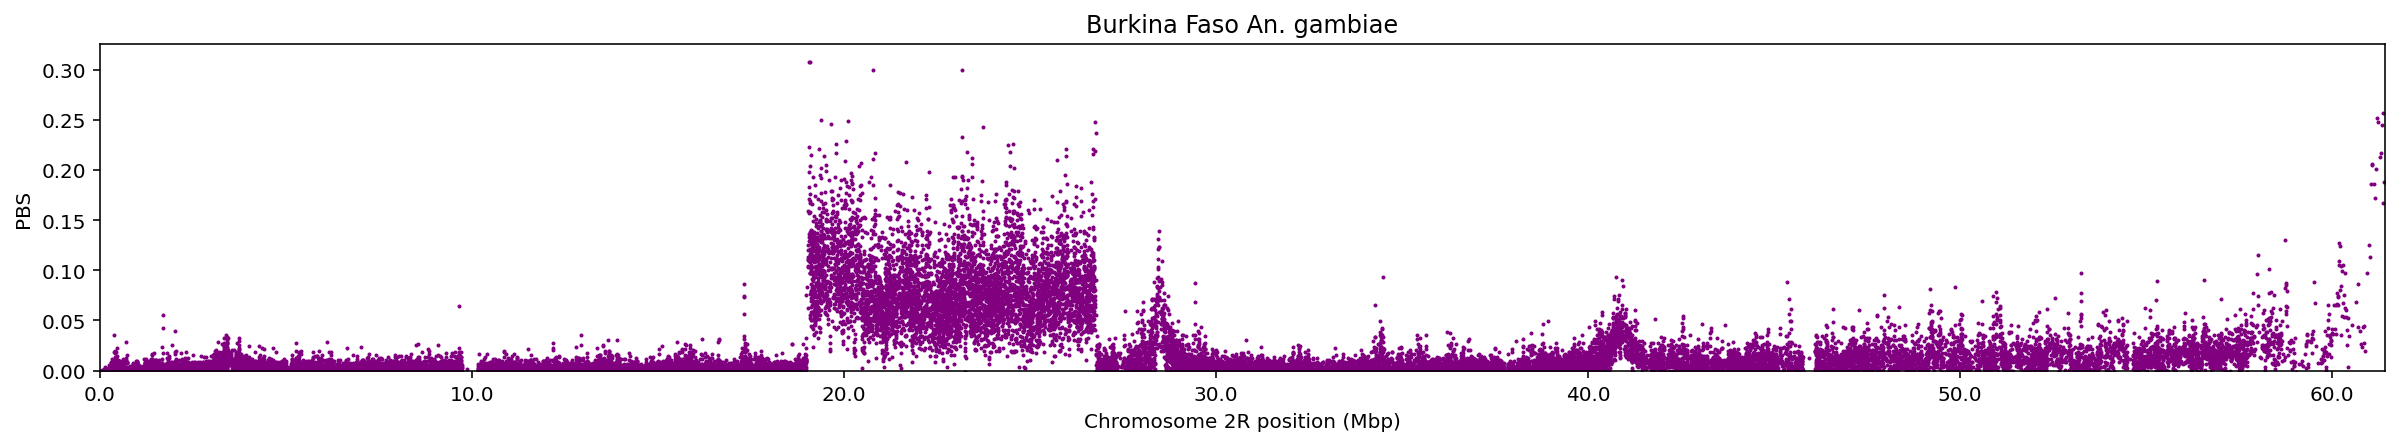

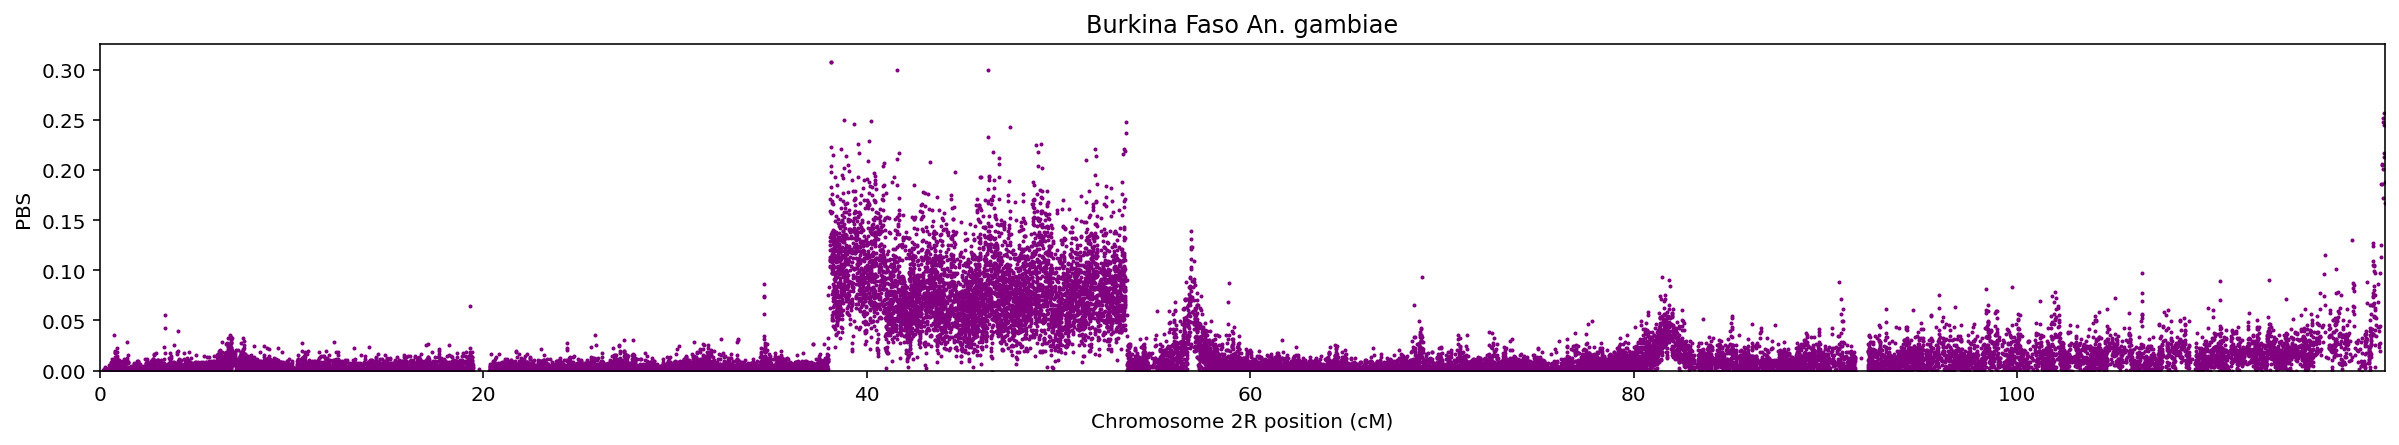

In [97]:
run_pbs('bf_gam', 'ug_gam', 'gw', '2R', window_size=300, window_step=300)

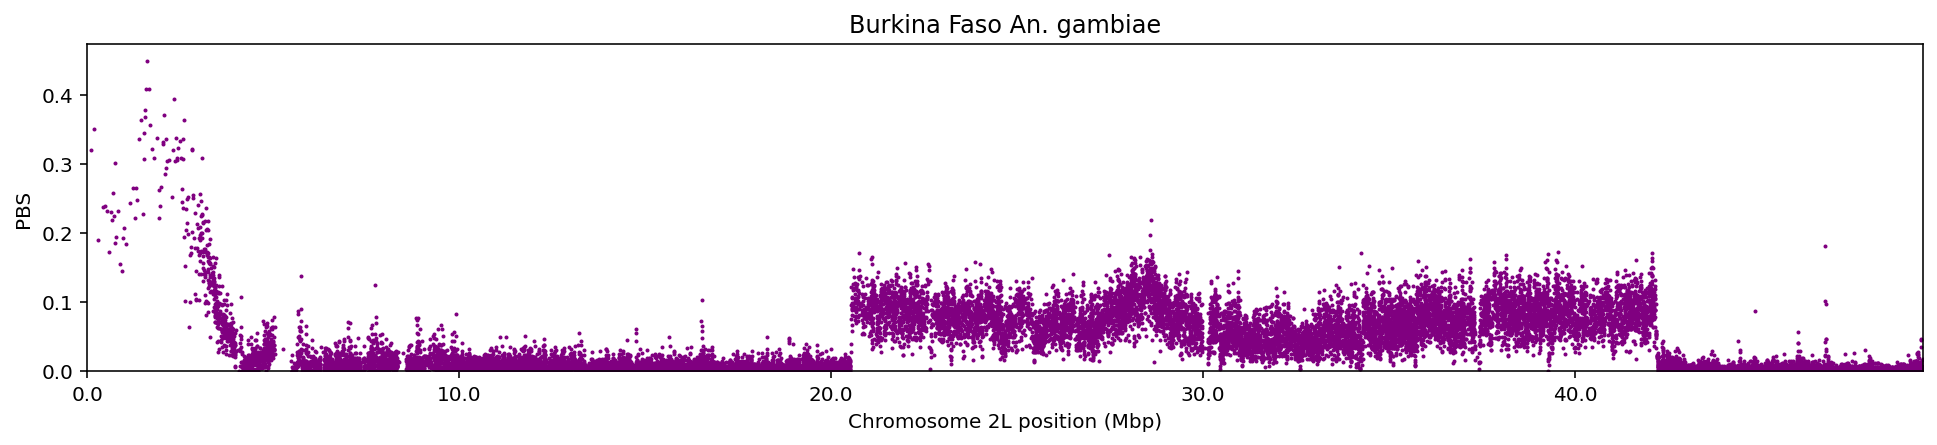

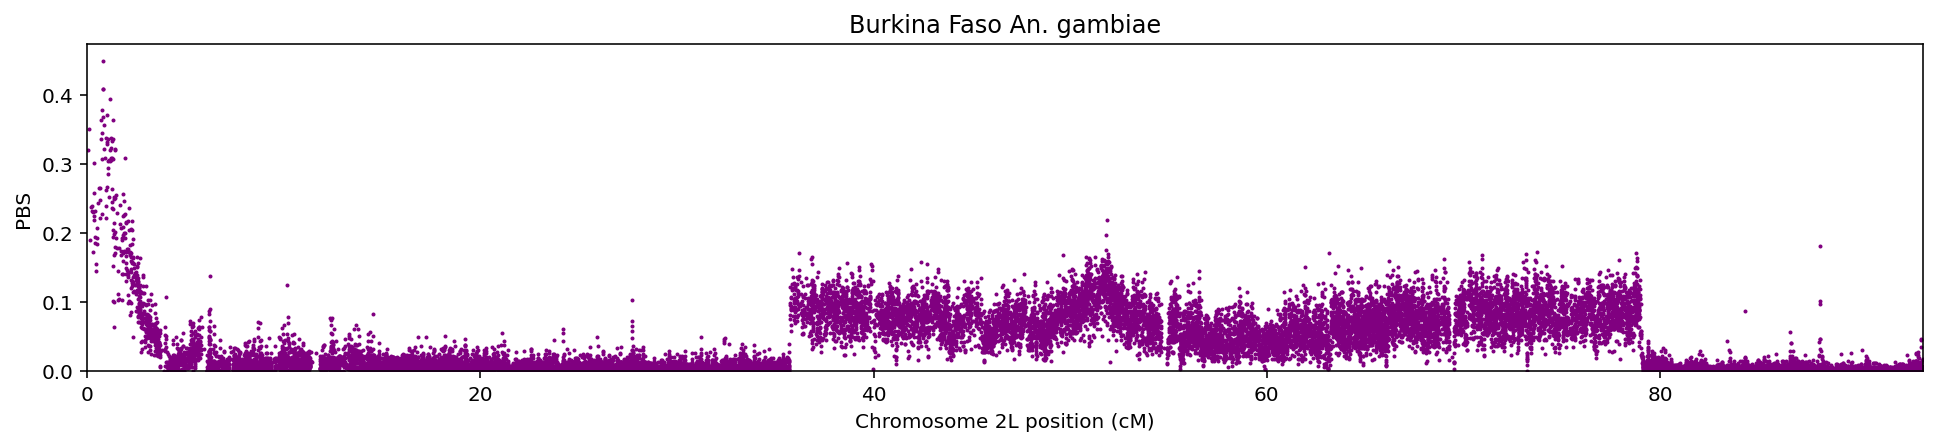

In [98]:
run_pbs('bf_gam', 'ug_gam', 'gw', '2L', window_size=300, window_step=300)